<a href="https://colab.research.google.com/github/jear2412/MCMC/blob/master/SoilCarbonModelling-emcee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:

import pandas as pd
import numpy as np
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
#import arviz as az
import scipy
from scipy.integrate import odeint
from scipy.stats.mstats import mquantiles
import emcee
sns.set()

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions


In [5]:
pip install emcee

In [49]:


def Analysis(x):
    mean=np.mean(x,0)
    median=np.median(x,0)
    var=np.var(x,0)

    ess=np.zeros( x.shape[1])
    for i in range( x.shape[1] ):
      ess[i]=tfp.mcmc.effective_sample_size(  x[:,i] , filter_beyond_positive_pairs=True)
    
    mess=np.min(ess)

    summary= {
        "Mean": mean,
        "Median":median,
        "Variance": var,
        "mVar": var/ess,
        "ess": ess,
        "mess":mess, #min ess

        }
    return summary

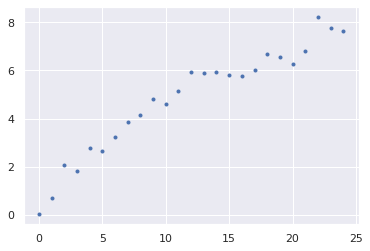

In [8]:



data=pd.read_csv('CO2-2.csv')
data=data.values

totalC_t0=7.7 #not included in data
t0=0
Nt=25
ts=data[0:25,1]
eco2mean=data[0:25,2]
eco2sd=data[0:25,3]


ts=ts.astype(float)
eco2mean=eco2mean.astype(float)
eco2sd=eco2sd.astype(float)







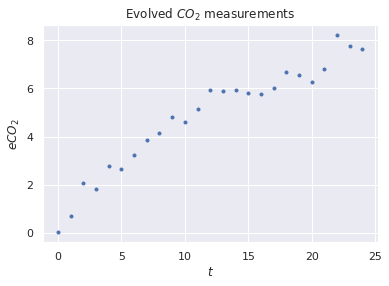

In [13]:
plt.plot(eco2mean,'.')
plt.xlabel( r'$t$' )
plt.ylabel( r'$ eCO_2$' )
plt.title( 'Evolved '+ r'$CO_2$' +' measurements' )
plt.savefig('ploteco2.png', dpi=250)
plt.show()


In [79]:
#Functions

def pplot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""

    # Summary statistics
    mean = np.mean( param )
    median = np.median( param )
    cred_min, cred_max = np.percentile( param, 2.5 ), np.percentile( param, 97.5 )

    # Plotting
    plt.subplot( 2, 1, 1 )
    plt.plot( param )
    plt.xlabel( 'samples' )
    plt.ylabel( param_name )
    plt.axhline( mean, color='r', lw=2, linestyle='--' )
    plt.axhline( median, color='c', lw=2, linestyle='--' )
    plt.axhline( cred_min, linestyle=':', color='k', alpha=0.2 )
    plt.axhline( cred_max, linestyle=':', color='k', alpha=0.2 )
    plt.title( 'Trace and Posterior Distribution for {}'.format( param_name ) )

    plt.subplot( 2, 1, 2 )
    plt.hist( param, 30, density=True );
    sns.kdeplot( param, shade=True )
    plt.xlabel( param_name )
    plt.ylabel( 'density' )
    plt.axvline( mean, color='r', lw=2, linestyle='--', label='mean' )
    plt.axvline( median, color='c', lw=2, linestyle='--', label='median' )
    plt.axvline( cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI' )
    plt.axvline( cred_max, linestyle=':', color='k', alpha=0.2 )

    plt.gcf().tight_layout()
    plt.legend()

def scODE( X,t, k1, k2, alpha21, alpha12):
    dC1dt= -k1*X[0]+ alpha12*k2*X[1]
    dC2dt= -k2*X[1]+ alpha21*k1*X[0]
    return np.array([ dC1dt, dC2dt  ])


def logPrior(theta):
    k1,k2,alpha21, alpha12, sigma, gamma=theta 
    if( all(theta>0) and gamma<1 ):
        a=np.sum(scipy.stats.halfnorm.logpdf([k1,k2,alpha21, alpha12]))
        b=scipy.stats.halfcauchy.logpdf(sigma)+scipy.stats.beta.logpdf(x=gamma, a=10, b=1)
        return a+b
    else:
        return -np.inf
    
    
def logL(theta):
    k1,k2,alpha21, alpha12, sigma, gamma=theta 
    X0=np.array( [ gamma*totalC_t0, (1-gamma)*totalC_t0 ] )
    Xt = odeint( scODE, X0, ts, args=( k1, k2, alpha21, alpha12),)
    C1t=Xt[:,0]
    C2t=Xt[:,1]
    eCO2hat= totalC_t0-( C1t+C2t)
    eCO2hat[eCO2hat<0]=0

    ll=np.sum(scipy.stats.norm.logpdf( x=eco2mean , loc=eCO2hat,scale=sigma))
    return ll


def logPosterior(theta):
    k1,k2,alpha21, alpha12, sigma, gamma=theta 
    if( all(theta>0) and gamma<1 and sigma<1 ):
        temp=logPrior(theta)+logL(theta)
        return temp
    else:
        return -np.inf
    
    
 

def p0_emcee(nwalkers=1):
    p0=scipy.stats.uniform.rvs(0, 1, [nwalkers,6])    
    
    return p0



In [80]:
import os

os.environ["OMP_NUM_THREADS"] = "4"

from multiprocessing import Pool
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

2 CPUs


In [81]:
#emcee

nwalkers = 20
T=50000

bi=int(0.15*T)

ndim=6

with Pool() as pool:
    sampler =  emcee.EnsembleSampler(nwalkers, ndim, logPosterior, pool=pool )
    sampler.run_mcmc( p0_emcee(nwalkers) , T, progress=True)

  




100%|██████████| 50000/50000 [22:42<00:00, 36.71it/s]


In [82]:

emcee_chains = sampler.get_chain()
samples=sampler.get_chain(flat=True)    

In [83]:
k1=samples[2*bi:,0]
k2=samples[2*bi:,1]
alpha21=samples[2*bi:,2]
alpha12=samples[2*bi:,3]
sigma=samples[2*bi:,4]
gamma=samples[2*bi:,5]

#results emcee
rmc={ 'k1':k1, 'k2':k2, 'alpha21':alpha21, 'alpha12':alpha12 , 'sigma': sigma, 'gamma': gamma    }
rmc=pd.DataFrame(rmc)

In [84]:
pd.DataFrame.describe(rmc)

,k1,k2,alpha21,alpha12,sigma,gamma
count,985000.000000,985000.000000,985000.000000,985000.000000,985000.000000,985000.000000
mean,0.360078,0.790727,0.678977,0.715444,0.356669,0.906274
std,0.425043,0.584918,0.337911,0.407873,0.053989,0.080386
min,0.059158,0.001062,0.000076,0.000028,0.196779,0.373367
25%,0.102832,0.315033,0.426504,0.436220,0.318867,0.865632
50%,0.175925,0.657853,0.719166,0.685872,0.351513,0.926952
75%,0.407574,1.123379,0.920762,0.921162,0.387887,0.968152
max,3.026761,4.409743,2.752193,3.224032,0.774109,1.000000


In [85]:
pd.DataFrame.median(rmc)

k1         0.175925
k2         0.657853
alpha21    0.719166
alpha12    0.685872
sigma      0.351513
gamma      0.926952
dtype: float64

In [86]:
qs=pd.DataFrame.quantile(rmc, (0.025, 0.975))
qs

,k1,k2,alpha21,alpha12,sigma,gamma
0.025,0.073783,0.093960,0.055978,0.056166,0.267295,0.697504
0.975,1.599049,2.228481,1.329152,1.693723,0.479796,0.996994


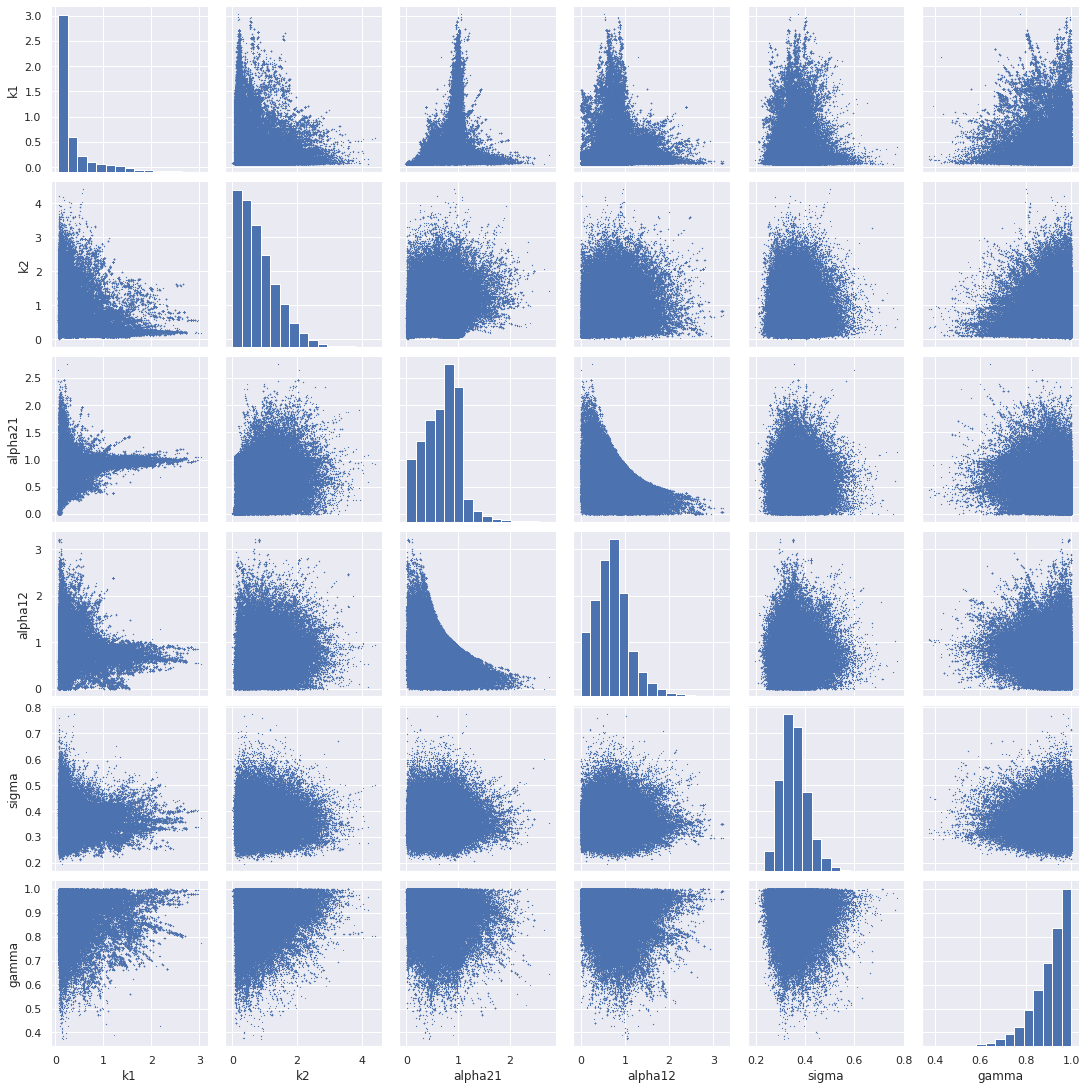

In [87]:

sns.pairplot(rmc, markers='.', plot_kws=dict(s=0.5, edgecolor="b"),diag_kws=dict(bins=15) )
plt.savefig('nicepairplotSoilCarbonmc.png', dpi=500)

In [88]:
q1=qs.iloc[0]
q2=qs.iloc[1]
q1=pd.Series.to_numpy(q1)
q2=pd.Series.to_numpy(q2)

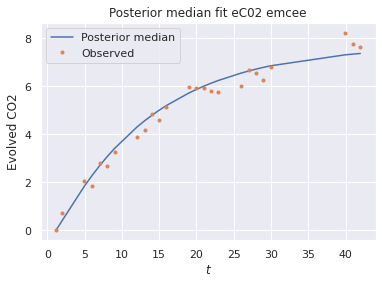

In [89]:
#medians
mk1=np.median(k1)
mk2=np.median(k2)
malpha21=np.median(alpha21)
malpha12=np.median(alpha12)
msigma=np.median(sigma)
mgamma=np.median(gamma)

#median
X0=np.array( [  mgamma*totalC_t0, (1-mgamma)*totalC_t0  ]  )
Xt= odeint( scODE, X0, ts, args=(  mk1,mk2,malpha21, malpha12, ))
C1t=Xt[:,0]
C2t=Xt[:,1]
eCO2hat= totalC_t0-( C1t+C2t)


#q1
#X0=np.array( [  q1[5]*totalC_t0, (1-q1[5])*totalC_t0  ]  )
#Xt= odeint( scODE, X0, ts, args=(  q1[0],q1[1],q1[2],q1[3], ))
#q1C1t=Xt[:,0]
#q1C2t=Xt[:,1]
#q1eCO2hat= totalC_t0-( q1C1t+q1C2t)

#q2
#X0=np.array( [  q2[5]*totalC_t0, (1-q2[5])*totalC_t0  ]  )
#Xt= odeint( scODE, X0, ts, args=(  q2[0],q2[1],q2[2],q2[3], ))
#q2C1t=Xt[:,0]
#q2C2t=Xt[:,1]
#q2eCO2hat= totalC_t0-( q2C1t+q2C2t)

plt.plot(ts, eCO2hat  , label='Posterior median' )
plt.plot(ts, eco2mean  , '.' ,label='Observed' )
#plt.plot(ts, q2eCO2hat  , '.' ,label='Observed' )
#plt.fill_between( ts, q1eCO2hat, q2eCO2hat , alpha=0.6, color='red')
plt.xlabel( r'$t$' )
plt.ylabel( r'Evolved CO2' )
plt.title( 'Posterior median fit eC02 emcee' )
plt.legend()
plt.savefig( 'eCO2-posteriormedianmc.png', dpi=500  )
plt.show()


In [52]:
AnalysisSamples=Analysis(samples)
AnalysisSamples

{'Mean': array([0.26607318, 0.76194413, 0.64253092, 0.64061867, 0.35849164,
        0.91319952]),
 'Median': array([0.13962221, 0.62663307, 0.65692817, 0.61314465, 0.34592809,
        0.93425222]),
 'Variance': array([0.09455004, 0.32918954, 0.1282972 , 0.16424632, 0.01463161,
        0.00621029]),
 'ess': array([7.91217168e+05, 2.12441435e+02, 9.28377956e+05, 7.75848939e+05,
        7.27042892e+02, 9.23295506e+05]),
 'mVar': array([1.19499486e-07, 1.54955428e-03, 1.38195005e-07, 2.11698838e-07,
        2.01248186e-05, 6.72622577e-09]),
 'mess': 212.44143545849278}

In [90]:
 sampler.get_autocorr_time(tol=0)

array([3641.62217176, 1802.86142304, 1739.72853694, 1357.98326846,
        865.65996255, 1200.89480664])

In [58]:
#-------- the t-walk

def U(theta):
    k1,k2,alpha21, alpha12, sigma, gamma=theta 
    if( all(theta>0) and gamma<1 ):
        temp=logPrior(theta)+logL(theta)
        return -temp
    else:
        return np.inf
    
def supp(theta):
    k1,k2,alpha21, alpha12, sigma, gamma=theta 
    if( all(theta>0) and gamma<1 ):
        return True
    else:
        return False

 

def p0t(nwalkers=1):
    p0=scipy.stats.uniform.rvs(0, 1, 6)    
    
    return p0

import pytwalk

In [64]:
T=1000000
bi=int(0.15*T)
tchain = pytwalk.pytwalk( n=6, U=U, Supp=supp )
tchain.Run( T=T , x0= p0t() , xp0=p0t()  )


pytwalk: Running the twalk with 1000000 iterations .  Wed, 01 Jul 2020, 21:52:50.
       Finish by Wed, 01 Jul 2020, 23:16.


/content/pytwalk.py:304: RuntimeWarning: overflow encountered in exp
  A = exp(up - up_prop)
/content/pytwalk.py:380: RuntimeWarning: overflow encountered in exp
  A = exp((up - up_prop) + (W1 - W2))


pytwalk:      27648 iterations so far. Finish by Wed, 01 Jul 2020, 22:11.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
/content/pytwalk.py:393: RuntimeWarning: overflow encountered in exp
  A = exp((u - u_prop) + (W1 - W2))


pytwalk:      80896 iterations so far. Finish by Wed, 01 Jul 2020, 22:11.


/usr/local/lib/python3.6/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


pytwalk:     189440 iterations so far. Finish by Wed, 01 Jul 2020, 22:11.


/content/pytwalk.py:318: RuntimeWarning: overflow encountered in exp
  A = exp(u - u_prop)


pytwalk:     420864 iterations so far. Finish by Wed, 01 Jul 2020, 22:10.
pytwalk:     870400 iterations so far. Finish in approx. 2 min and 19 sec.
pytwalk: finished, Wed, 01 Jul 2020, 22:10:39.


1

In [76]:
tchain.IAT()

AutoMaxlag: maxlag= 1216.


matrix([[156.404609]])

In [65]:
k1=tchain.Output[bi:,0]
k2=tchain.Output[bi:,1]
alpha21=tchain.Output[bi:,2]
alpha12=tchain.Output[bi:,3]
sigma=tchain.Output[bi:,4]
gamma=tchain.Output[bi:,5]

#results t
rtw={ 'k1':k1, 'k2':k2, 'alpha21':alpha21, 'alpha12':alpha12 , 'sigma': sigma, 'gamma': gamma    }
rtw=pd.DataFrame(rtw)

In [66]:
pd.DataFrame.describe(rtw)

,k1,k2,alpha21,alpha12,sigma,gamma
count,850001.000000,850001.000000,850001.000000,850001.000000,850001.000000,850001.000000
mean,0.269345,0.785759,0.614946,0.674797,0.360704,0.914088
std,0.369702,0.603296,0.377766,0.420825,0.060929,0.078827
min,0.011445,0.024799,0.001049,0.000094,0.151280,0.376097
25%,0.090975,0.310440,0.313776,0.359167,0.318477,0.879549
50%,0.127739,0.649886,0.606249,0.643445,0.352528,0.936708
75%,0.263878,1.095774,0.860190,0.903231,0.394359,0.971832
max,3.456676,4.092346,3.979963,3.060014,0.768847,0.999984


In [67]:
pd.DataFrame.median(rtw)

k1         0.127739
k2         0.649886
alpha21    0.606249
alpha12    0.643445
sigma      0.352528
gamma      0.936708
dtype: float64

In [68]:
qs=pd.DataFrame.quantile(rmc, (0.025, 0.975))
qs


,k1,k2,alpha21,alpha12,sigma,gamma
0.025,0.072009,0.091411,0.041573,0.038131,0.265897,0.707879
0.975,1.191138,2.186016,1.375216,1.619138,0.476999,0.997518


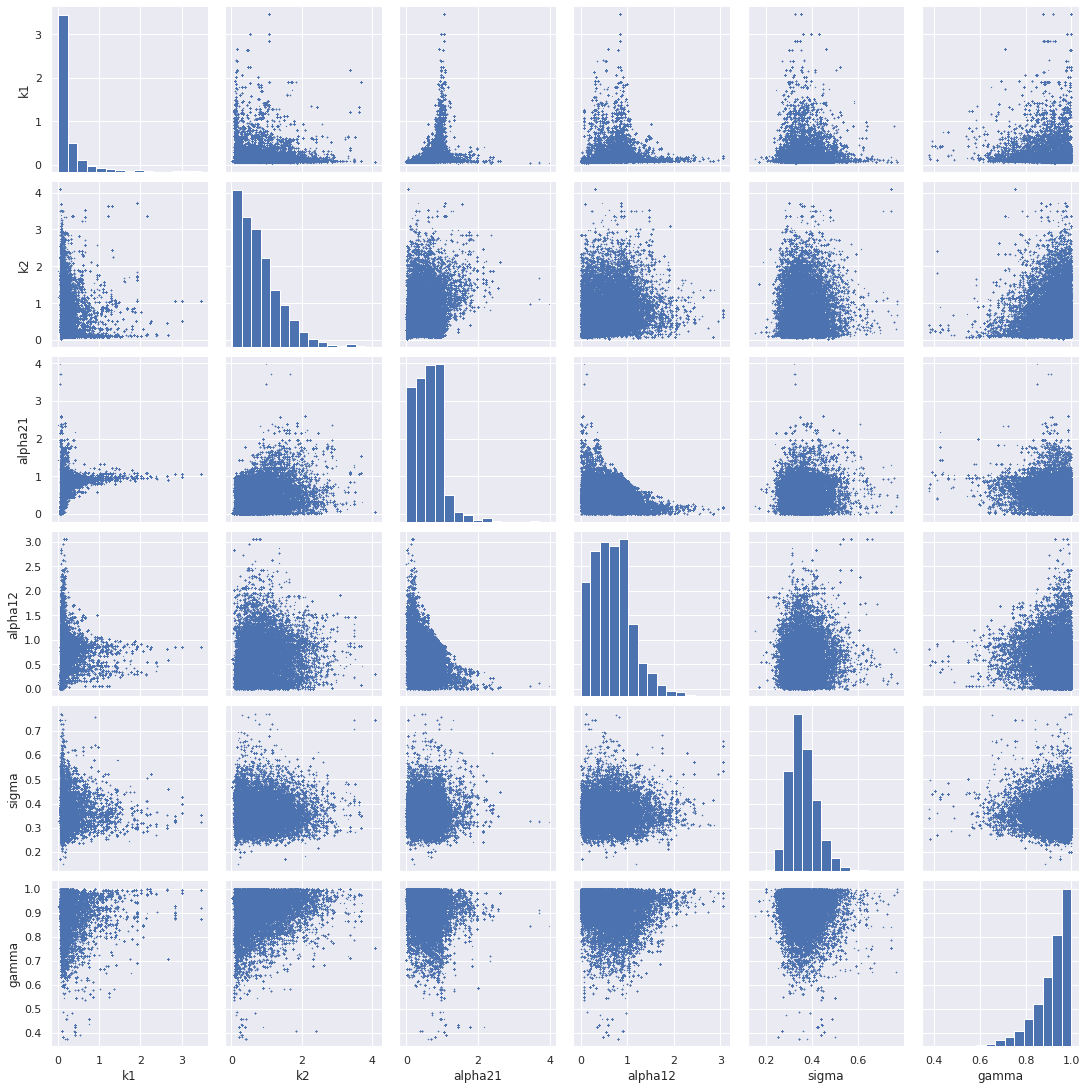

In [78]:

sns.pairplot(rtw, markers='.', plot_kws=dict(s=0.5, edgecolor="b"),diag_kws=dict(bins=15) )
plt.savefig('nicepairplotSoilCarbontw.png', dpi=500)

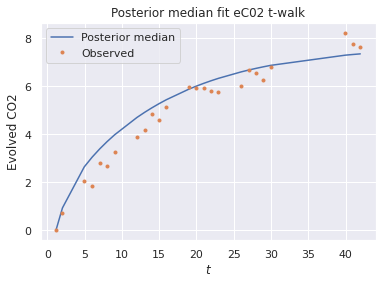

In [75]:
#medians
#sacar medians

mds=pd.DataFrame.median(rtw)
#mds=mds.iloc[0]
mds=pd.Series.to_numpy(mds)


mk1=mds[0]
mk2=mds[1]
malpha21=mds[2]
malpha12=mds[3]
mgamma=mds[4]

#median
X0=np.array( [  mgamma*totalC_t0, (1-mgamma)*totalC_t0  ]  )
Xt= odeint( scODE, X0, ts, args=(  mk1,mk2,malpha21, malpha12, ))
C1t=Xt[:,0]
C2t=Xt[:,1]
eCO2hat= totalC_t0-( C1t+C2t)


#q1
#X0=np.array( [  q1[5]*totalC_t0, (1-q1[5])*totalC_t0  ]  )
#Xt= odeint( scODE, X0, ts, args=(  q1[0],q1[1],q1[2],q1[3], ))
#q1C1t=Xt[:,0]
#q1C2t=Xt[:,1]
#q1eCO2hat= totalC_t0-( q1C1t+q1C2t)

#q2
#X0=np.array( [  q2[5]*totalC_t0, (1-q2[5])*totalC_t0  ]  )
#Xt= odeint( scODE, X0, ts, args=(  q2[0],q2[1],q2[2],q2[3], ))
#q2C1t=Xt[:,0]
#q2C2t=Xt[:,1]
#q2eCO2hat= totalC_t0-( q2C1t+q2C2t)

plt.plot(ts, eCO2hat  , label='Posterior median' )
plt.plot(ts, eco2mean  , '.' ,label='Observed' )
#plt.plot(ts, q2eCO2hat  , '.' ,label='Observed' )
#plt.fill_between( ts, q1eCO2hat, q2eCO2hat , alpha=0.6, color='red')
plt.xlabel( r'$t$' )
plt.ylabel( r'Evolved CO2' )
plt.title( 'Posterior median fit eC02 t-walk' )
plt.legend()
plt.savefig( 'eCO2-posteriormediantw.png', dpi=500  )
plt.show()


In [73]:
mds=pd.DataFrame.median(rtw)
#mds=mds.iloc[0]
mds=pd.Series.to_numpy(mds)



array([0.12773908, 0.64988636, 0.6062485 , 0.64344507, 0.35252789,
       0.9367075 ])